## Brain MRI Project

For this project we will use some images of Brain MRIs and we will build a model that knows how to identify between the 4 classes that the images belong to.

The dataset is from [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?select=Training). 
<br>It contains 7023 images, belonging to 4 different classes:  glioma - meningioma - no tumor and pituitary.
<br>Let us proceed with our imports and previewing the images.

#### Imports

In [57]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="white")

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage import io
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

#### Creating the datasets

In [2]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Previewing an image from the train set:

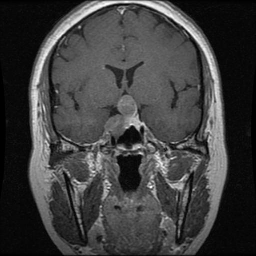

In [3]:
# Preview an image
array_to_img(train_images[0])

Previewing an image from the test set:

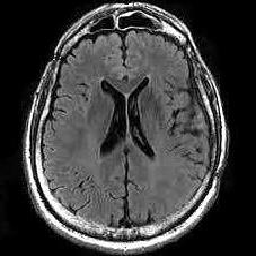

In [4]:
# Preview an image
array_to_img(test_images[0])

Now let us explore more the division among the classes and we will preview one image per class.

In [5]:
test_images.shape

(1311, 256, 256, 3)

In [6]:
train_images.shape

(5712, 256, 256, 3)

This shows us that the dimension of the imgaes is 256x256 and the sample that was taken from the image generator contains all the images for train and test.

Now we will generate a dataframe for the train images, first let us look at the classes:

In [7]:
train_generator.class_indices 

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [8]:
df_train=pd.DataFrame(train_labels, columns=['glioma', 'meningioma',\
            'notumor', 'pituitary'])

Let us preview it:

In [9]:
df_train

,glioma,meningioma,notumor,pituitary
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
5707,0.0,0.0,1.0,0.0
5708,1.0,0.0,0.0,0.0
5709,0.0,1.0,0.0,0.0
5710,0.0,0.0,1.0,0.0


In [10]:
df_train.value_counts()

glioma  meningioma  notumor  pituitary
0.0     0.0         1.0      0.0          1595
                    0.0      1.0          1457
        1.0         0.0      0.0          1339
1.0     0.0         0.0      0.0          1321
dtype: int64

In [11]:
sums=df_train.sum(axis=0)
sums=pd.DataFrame(sums)
sums.rename(columns={0: "Counts"}, inplace=True)
sums

,Counts
glioma,1321.0
meningioma,1339.0
notumor,1595.0
pituitary,1457.0


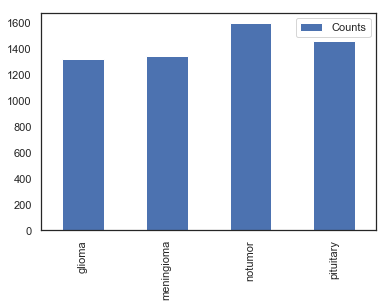

In [12]:
sums['Counts'].plot(kind='bar', legend=True);

#### Repeating for the test:

In [13]:
test_generator.class_indices 

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [14]:
df_test=pd.DataFrame(test_labels, columns=['glioma', 'meningioma',\
            'notumor', 'pituitary'])

In [15]:
df_test

,glioma,meningioma,notumor,pituitary
0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
1306,0.0,0.0,1.0,0.0
1307,0.0,0.0,0.0,1.0
1308,0.0,1.0,0.0,0.0
1309,1.0,0.0,0.0,0.0


In [16]:
sums_test=df_test.sum(axis=0)
sums_test=pd.DataFrame(sums_test)
sums_test.rename(columns={0: "Counts"}, inplace=True)
sums_test

,Counts
glioma,300.0
meningioma,306.0
notumor,405.0
pituitary,300.0


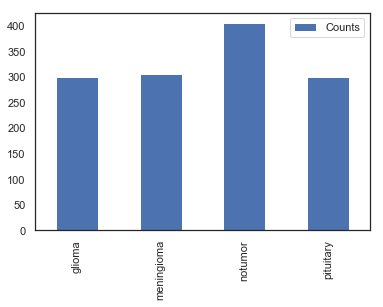

In [17]:
sums_test['Counts'].plot(kind='bar', legend=True);

Now that we saw the distribution of the images we can say that the classes are pretty well balanced and hopefully we shouldn't have problems of imbalanced classes.

Next we need to do some data manipulation to prepare the labels to be used when we run and fit the model.
As we saw right now the labels for each class are all the same, '1'. But we will have to collapse the labels into one dimensional array to be able to feed it to the model, so we need to assign different labels to each class to be able to distinguish between them. We will do this by simply creating a dictionary and reassigning the labels.

In [18]:
df_train.replace({'notumor': 1.0}, 0, inplace=True)
df_train.replace({'glioma': 1.0}, 1, inplace=True)
df_train.replace({'meningioma': 1.0}, 2, inplace=True)
df_train.replace({'pituitary': 1.0}, 3, inplace=True)

In [19]:
df_train

,glioma,meningioma,notumor,pituitary
0,0.0,0.0,0.0,3.0
1,1.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,3.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
5707,0.0,0.0,0.0,0.0
5708,1.0,0.0,0.0,0.0
5709,0.0,2.0,0.0,0.0
5710,0.0,0.0,0.0,0.0


Creating a new column '1D' that will be our 1 dimensional array of labels.

In [20]:
df_train['1D']=df_train['glioma']+df_train['meningioma']+df_train['notumor']+df_train['pituitary']

In [21]:
df_train

,glioma,meningioma,notumor,pituitary,1D
0,0.0,0.0,0.0,3.0,3.0
1,1.0,0.0,0.0,0.0,1.0
2,0.0,2.0,0.0,0.0,2.0
3,0.0,0.0,0.0,3.0,3.0
4,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
5707,0.0,0.0,0.0,0.0,0.0
5708,1.0,0.0,0.0,0.0,1.0
5709,0.0,2.0,0.0,0.0,2.0
5710,0.0,0.0,0.0,0.0,0.0


Now we just need to turn this column into a numpy array and that will be perfect to be used as the y in our model:

In [22]:
train_y=df_train['1D'].to_numpy()
train_y

array([3., 1., 2., ..., 2., 0., 0.], dtype=float32)

Repeating the same steps for the test:

In [23]:
df_test.replace({'notumor': 1.0}, 0, inplace=True)
df_test.replace({'glioma': 1.0}, 1, inplace=True)
df_test.replace({'meningioma': 1.0}, 2, inplace=True)
df_test.replace({'pituitary': 1.0}, 3, inplace=True)

In [24]:
df_test['1D']=df_test['glioma']+df_test['meningioma']+df_test['notumor']+df_test['pituitary']

In [25]:
test_y=df_test['1D'].to_numpy()
test_y

array([0., 1., 3., ..., 2., 1., 1.], dtype=float32)

Perfect, now we are almost ready to start making and running our models.

#### Building some functions:

Building some functions that will help us visualize and compare the different models.
The first function we are defining is to visualize the curve of accuracy and loss, as they develop along the epochs, both for the train and validation set.
We are extracting these values from the history that the model produces once it is fit.

In [26]:
def visualize_training_results(results):
#Extracting the history from the results of the model
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#Plotting Train and Validation Accuracy
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
#Setting legend, title and labels
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
#Plotting Train and Validation Loss    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
#Setting legend, title and labels
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Defining a function to fit the model and get the results. Also here we can set number of epochs, batch size and validation split, but there are default parameters too. In particular we set verbose to zero because we don't want to print out the fitting of all the models. We also set a default validation split of 20%, which is a standard amount, to have a part of the data that the model can do validation on.

In [27]:
#Defining function with some sest parameters
def fit_model(model, X, y, epo=15, batch=30, val_split=0.2, verbose=0):
    #Fitting the model and storing the results in the variable 'results'
    results = model.fit(X, y, epochs=epo, batch_size=batch, 
                        validation_split=val_split, verbose=verbose)
    return results

At last we are going to be creating a function to preview and store the results of our models. With this function we will display the evolution of accuracy and loss in our model, during the different epochs.
Below that we will see also the values of accuracy and loss and over time we will build a learning curve, adding the result of each previous model and the current one, to see if our model is improving.
We are also saving the results into a DataFrame that we will keep updating with the new results, to have them also in a convenient tabular format.

In [28]:
#Defining the function
def model_results(model, results, model_name, df, trainX, trainy ):
    #First we want the function to display the history of accuracy and loss, with the function previously defined
    visualize_training_results(results)
    #Creating a temporary DataFrame to store the results obtained
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': results.history['acc'][-1] ,
        'accuracy validation': results.history['val_acc'][-1],
        'loss train': results.history['loss'][-1],
        'loss validation': results.history['val_loss'][-1]})
    #Appending the results of the current model to the general DataFrame 'df' with results of all models
    df=df.append(df1)
    #Plotting learning curves of Accuracy and Loss
    fig = plt.subplots(figsize=(12,6))
    #First Subplot, accuracy of train and validation
    #This takes resulta from df, plotting the results from current and previous models
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='c')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='m')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
    #Second Subplot, loss of train and validation
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='c')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='m')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

Next we are going to build a first naive CNN model that we will use as our baseline or naive model.

#### Naive Model:

Importing Images:

In [59]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(16, 16), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(16, 16),batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Creating a first basic model.
This model will have images of size 16x16 as input, and only one convolutional layer with 3 neurons, and one pooling layer.
The final Dense layer has to have 4 neurons because that corresponds with the number of classes that we are trying to identify for our images.

In [60]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(16,16,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Fitting the model:

In [61]:
history = fit_model(model, train_images, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 4s 5ms/step - loss: 26.6229 - acc: 0.2507 - val_loss: 1.3862 - val_acc: 0.2861
Epoch 2/10
457/457 [==============================] - 1s 3ms/step - loss: 1.3867 - acc: 0.2729 - val_loss: 1.3838 - val_acc: 0.2861
Epoch 3/10
457/457 [==============================] - 2s 5ms/step - loss: 1.3825 - acc: 0.2889 - val_loss: 1.3831 - val_acc: 0.2852
Epoch 4/10
457/457 [==============================] - 1s 3ms/step - loss: 1.3838 - acc: 0.2731 - val_loss: 1.3827 - val_acc: 0.2861
Epoch 5/10
457/457 [==============================] - 2s 3ms/step - loss: 1.3836 - acc: 0.2791 - val_loss: 1.3829 - val_acc: 0.2852
Epoch 6/10
457/457 [==============================] - 2s 3ms/step - loss: 1.3845 - acc: 0.2780 - val_loss: 1.3829 - val_acc: 0.2861
Epoch 7/10
457/457 [==============================] - 2s 4ms/step - loss: 1.3837 - acc: 0.2809 - val_loss: 1.3828 - val_acc: 0.2861
Epoch 8/10
457/457 [==============================] - 8s 17ms/step - loss: 

Creating an empty dataframe to store the results:

In [62]:
df_res=pd.DataFrame()

Saving and previewing the results:

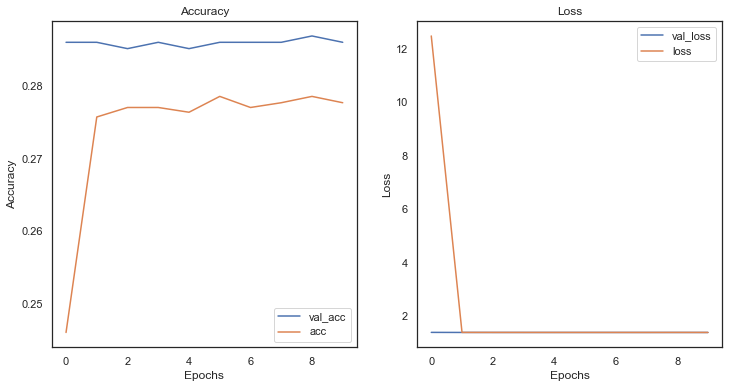

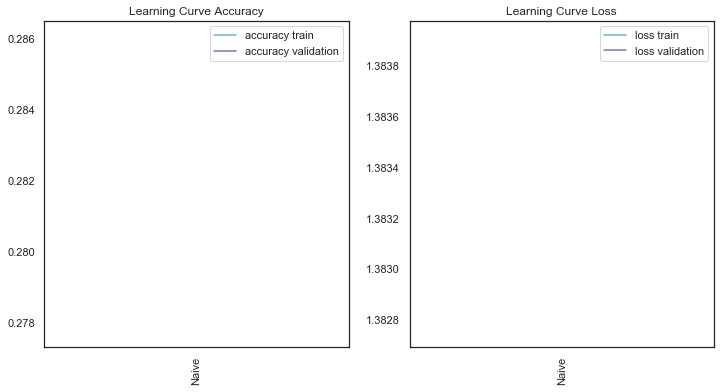

In [63]:
df_res=model_results(model, history, 'Naive', df_res, train_images, train_labels)

In [64]:
df_res

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.277741,0.286089,1.383918,1.382752


This is a very primitive model so we expect the results to not be particularly good.
Given that there are 4 possible classes, the accuracy of a "random" model (choosing the class of the image completely at random) would be around 25%, which is what we are seeing here.
Now we will take the necessary steps to try and improve the performance of our model.

#### Increasing Image Size
The first thing that we should reasonably do is to increase the image size, we will import the images again this time with size 32x32.

In [65]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(32, 32), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32),batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Next we will create a model exactly like our previous one, but changing the input shape, so we are changing only one variable.

In [66]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(32,32,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [67]:
history1 = fit_model(model, train_images, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 3s 6ms/step - loss: 3.8621 - acc: 0.2574 - val_loss: 1.3870 - val_acc: 0.2861
Epoch 2/10
457/457 [==============================] - 3s 6ms/step - loss: 1.3841 - acc: 0.2764 - val_loss: 1.3832 - val_acc: 0.2861
Epoch 3/10
457/457 [==============================] - 3s 6ms/step - loss: 1.3829 - acc: 0.2866 - val_loss: 1.3830 - val_acc: 0.2861
Epoch 4/10
457/457 [==============================] - 3s 6ms/step - loss: 1.3838 - acc: 0.2778 - val_loss: 1.3830 - val_acc: 0.2861
Epoch 5/10
457/457 [==============================] - 3s 7ms/step - loss: 1.3832 - acc: 0.2802 - val_loss: 1.3830 - val_acc: 0.2861
Epoch 6/10
457/457 [==============================] - 3s 7ms/step - loss: 1.3863 - acc: 0.2664 - val_loss: 1.3830 - val_acc: 0.2861
Epoch 7/10
457/457 [==============================] - 2s 5ms/step - loss: 1.3850 - acc: 0.2649 - val_loss: 1.3828 - val_acc: 0.2861
Epoch 8/10
457/457 [==============================] - 3s 6ms/step - loss: 1.

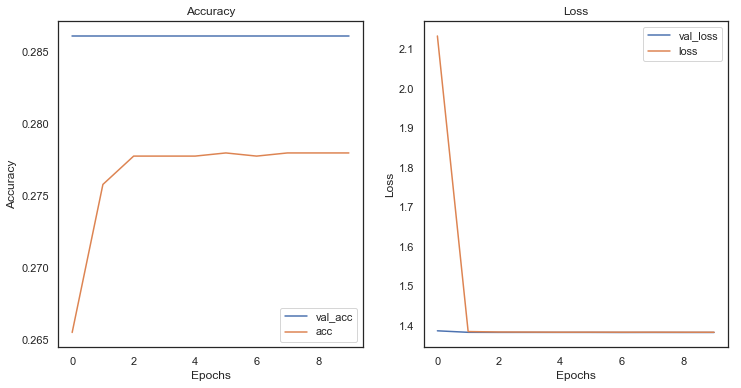

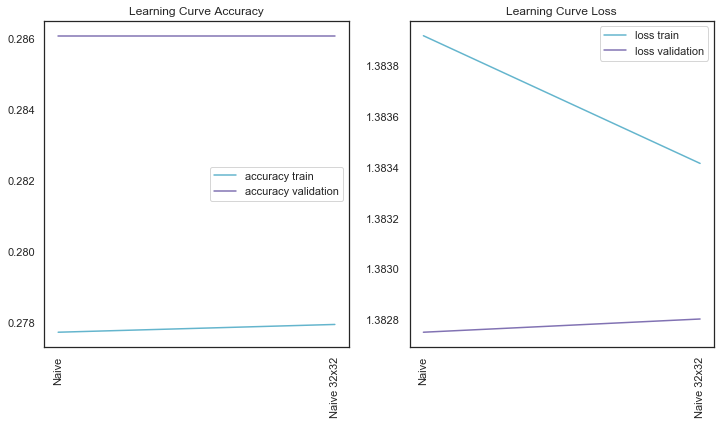

In [68]:
df_res=model_results(model, history1, 'Naive 32x32', df_res, train_images, train_labels)

We start to see the accuracy increasing for the train, which is encouraging. It did not increase for the validation but that might have to do with the very small batch (10 images) that we are using.
<br>We are first going to increase the images size further and then we will move on to changing the batch size and number of epochs.
<br>So let us proceed to increase the image size further, to 64x64.

In [69]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(64, 64), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64),batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Recreating the model:

In [70]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(64,64,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [71]:
history2 = fit_model(model, train_images, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 6s 13ms/step - loss: 74.1987 - acc: 0.2683 - val_loss: 1.3921 - val_acc: 0.2493
Epoch 2/10
457/457 [==============================] - 7s 16ms/step - loss: 1.3798 - acc: 0.2802 - val_loss: 1.3898 - val_acc: 0.2800
Epoch 3/10
457/457 [==============================] - 7s 16ms/step - loss: 1.3606 - acc: 0.3026 - val_loss: 1.4232 - val_acc: 0.2843
Epoch 4/10
457/457 [==============================] - 5s 12ms/step - loss: 1.3545 - acc: 0.3097 - val_loss: 1.4734 - val_acc: 0.2808
Epoch 5/10
457/457 [==============================] - 5s 10ms/step - loss: 1.3346 - acc: 0.3437 - val_loss: 1.4712 - val_acc: 0.2975
Epoch 6/10
457/457 [==============================] - 5s 10ms/step - loss: 1.3155 - acc: 0.3488 - val_loss: 1.4925 - val_acc: 0.2808
Epoch 7/10
457/457 [==============================] - 5s 11ms/step - loss: 1.3017 - acc: 0.3643 - val_loss: 1.5327 - val_acc: 0.2896
Epoch 8/10
457/457 [==============================] - 5s 11ms/step -

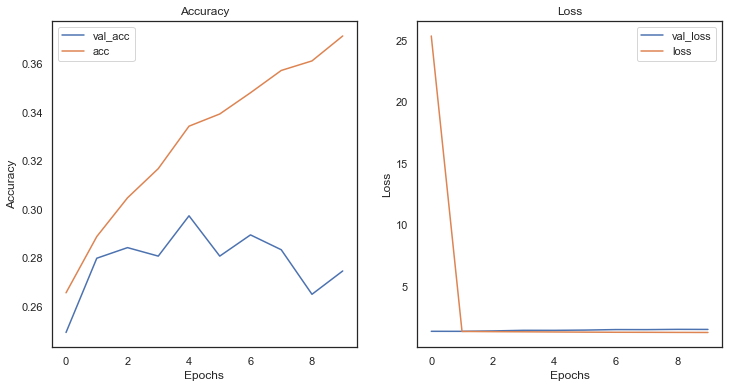

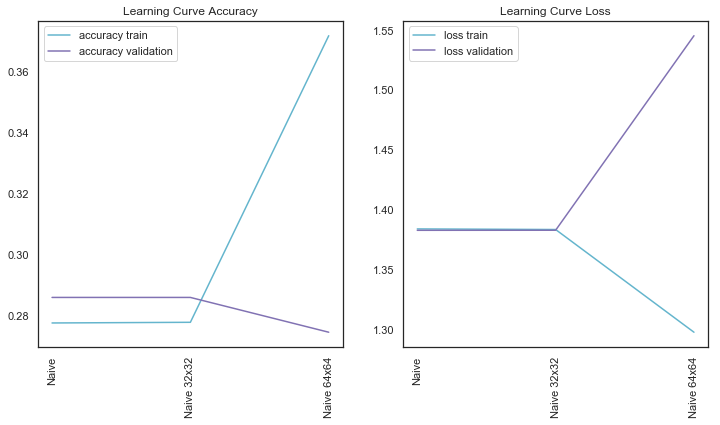

In [72]:
df_res=model_results(model, history2, 'Naive 64x64', df_res, train_images, train_y)

In [73]:
df_res

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.277741,0.286089,1.383918,1.382752
0,Naive 32x32,0.277960,0.286089,1.383416,1.382804
0,Naive 64x64,0.371635,0.274716,1.297568,1.545399


The results with this increase of size are have improved, but not tremendously.
<br>Importing images with size 132x132.

In [84]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(132,132), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(132,132),batch_size=5712)


# Create the datasets
train_images132, train_labels = next(train_generator)
test_images132, test_labels = next(test_generator)

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Creating the model:

In [85]:
# create model
#Sequential: multiple layers built on top of each other

model132 = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(132,132,3)))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model132.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model132.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model132.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [76]:
history3 = fit_model(model132, train_images132, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 20s 42ms/step - loss: 38.9686 - acc: 0.2421 - val_loss: 1.3877 - val_acc: 0.2843
Epoch 2/10
457/457 [==============================] - 22s 48ms/step - loss: 1.3729 - acc: 0.2962 - val_loss: 1.4261 - val_acc: 0.2625
Epoch 3/10
457/457 [==============================] - 18s 38ms/step - loss: 1.3282 - acc: 0.3652 - val_loss: 1.6255 - val_acc: 0.2563
Epoch 4/10
457/457 [==============================] - 19s 41ms/step - loss: 1.2944 - acc: 0.3938 - val_loss: 1.7551 - val_acc: 0.2450
Epoch 5/10
457/457 [==============================] - 20s 43ms/step - loss: 1.2591 - acc: 0.4211 - val_loss: 2.0211 - val_acc: 0.2476
Epoch 6/10
457/457 [==============================] - 23s 51ms/step - loss: 1.2314 - acc: 0.4407 - val_loss: 2.4027 - val_acc: 0.2423
Epoch 7/10
457/457 [==============================] - 23s 50ms/step - loss: 1.1909 - acc: 0.4843 - val_loss: 2.3332 - val_acc: 0.2520
Epoch 8/10
457/457 [==============================] - 20s 44m

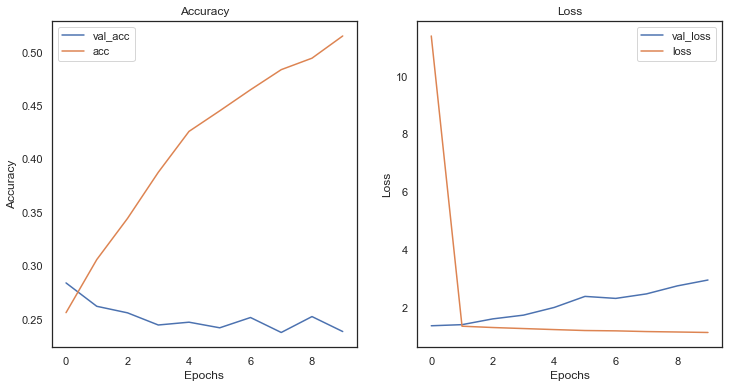

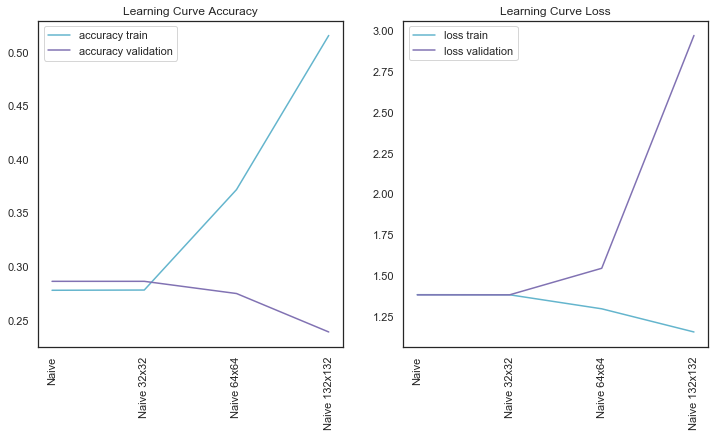

In [77]:
df_res=model_results(model132, history3, 'Naive 132x132', df_res, train_images132, train_y)

The results with the image size 132x132 show a great improvement but we start to see some overfitting.
<br>We will be able to handle this later in different ways. First let us try to increase the image size one more time to the full 256x256.

In [78]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(256,256), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(256,256),batch_size=5712)


# Create the datasets
train_images256, train_labels = next(train_generator)
test_images256, test_labels = next(test_generator)

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


In [79]:
# create model
#Sequential: multiple layers built on top of each other

model256 = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model256.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(256,256,3)))
#MaxPooling with filter size 2 and stride 2
model256.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model256.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model256.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model256.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [80]:
history4 = fit_model(model256, train_images256, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 82s 178ms/step - loss: 52.4463 - acc: 0.2519 - val_loss: 1.3856 - val_acc: 0.2843
Epoch 2/10
457/457 [==============================] - 87s 189ms/step - loss: 1.3600 - acc: 0.3261 - val_loss: 1.5447 - val_acc: 0.2931
Epoch 3/10
457/457 [==============================] - 72s 159ms/step - loss: 1.2941 - acc: 0.4009 - val_loss: 1.8891 - val_acc: 0.2791
Epoch 4/10
457/457 [==============================] - 70s 153ms/step - loss: 1.2168 - acc: 0.4750 - val_loss: 2.4548 - val_acc: 0.2651
Epoch 5/10
457/457 [==============================] - 68s 149ms/step - loss: 1.1373 - acc: 0.5237 - val_loss: 2.7254 - val_acc: 0.2616
Epoch 6/10
457/457 [==============================] - 83s 182ms/step - loss: 1.0839 - acc: 0.5847 - val_loss: 3.4504 - val_acc: 0.2423
Epoch 7/10
457/457 [==============================] - 74s 162ms/step - loss: 1.0170 - acc: 0.6163 - val_loss: 4.1321 - val_acc: 0.2353
Epoch 8/10
457/457 [==============================] - 

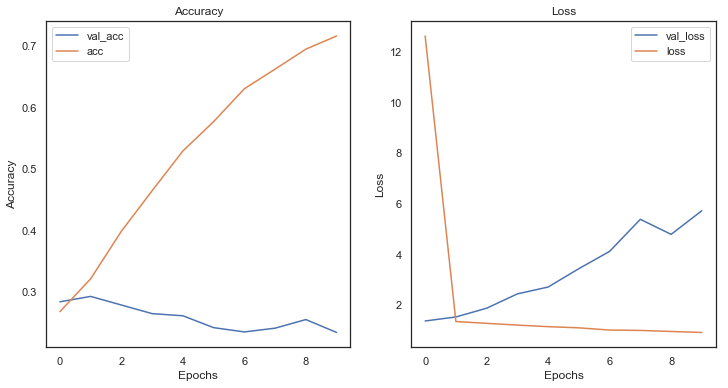

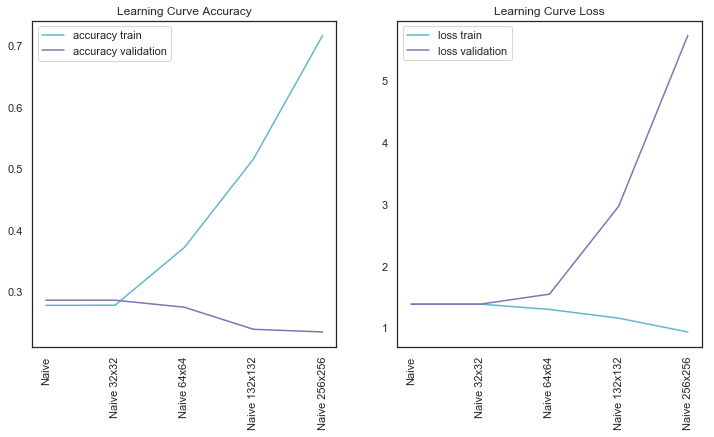

In [81]:
df_res=model_results(model256, history4, 'Naive 256x256', df_res, train_images256, train_y)

We can see how the performance has even further increased with the increase of the image size.
The issue with using larger images can be computational time but it definitely gives a chance to the model to learn at its best.
For now we will keep it this way, and start to increase number pf epochs and batch size.

#### Epochs and batch size
Let us see what happens if we keep our same model, but we give it a chance to learn over more epochs, and using a larger batch of images.

In [82]:
history5 = fit_model(model256, train_images256, train_y, epo=20, batch=20, verbose=1)

Epoch 1/20
229/229 [==============================] - 103s 444ms/step - loss: 0.8078 - acc: 0.7415 - val_loss: 6.1952 - val_acc: 0.2397
Epoch 2/20
229/229 [==============================] - 69s 301ms/step - loss: 0.7785 - acc: 0.7614 - val_loss: 7.1097 - val_acc: 0.2450
Epoch 3/20
229/229 [==============================] - 114s 501ms/step - loss: 0.7753 - acc: 0.7763 - val_loss: 7.4351 - val_acc: 0.2406
Epoch 4/20
229/229 [==============================] - 80s 350ms/step - loss: 0.6907 - acc: 0.7910 - val_loss: 7.4999 - val_acc: 0.2511
Epoch 5/20
229/229 [==============================] - 60s 260ms/step - loss: 0.6644 - acc: 0.8017 - val_loss: 7.6726 - val_acc: 0.2415
Epoch 6/20
229/229 [==============================] - 102s 445ms/step - loss: 0.6303 - acc: 0.8122 - val_loss: 8.8446 - val_acc: 0.2397
Epoch 7/20
229/229 [==============================] - 111s 486ms/step - loss: 0.6214 - acc: 0.8210 - val_loss: 8.6542 - val_acc: 0.2388
Epoch 8/20
229/229 [==============================]

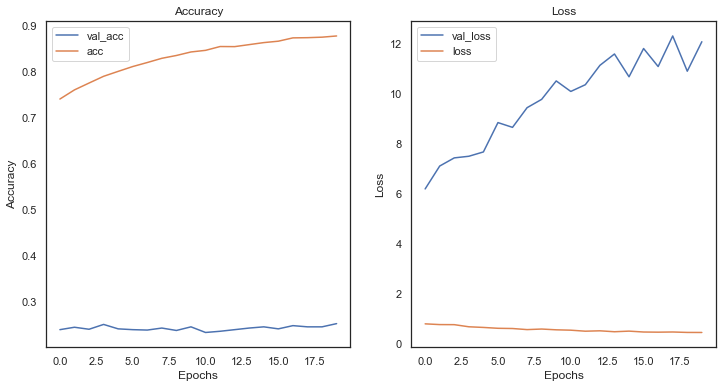

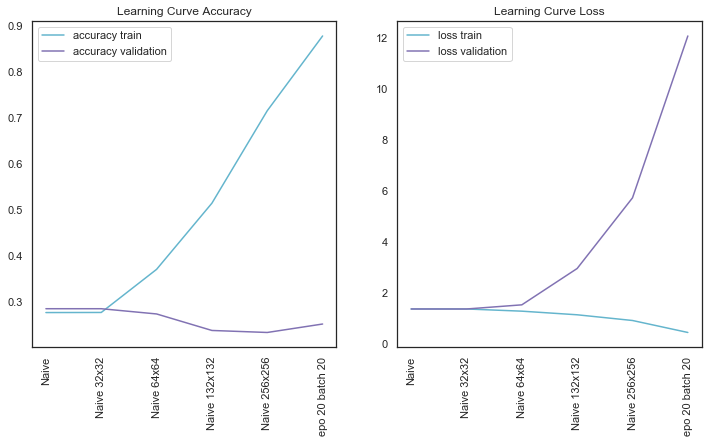

In [83]:
df_res=model_results(model256, history5, 'epo 20 batch 20', df_res, train_images256, train_y)

With longer epochs and a bigger batch, the accuracy of both train and validation has increased.
I will try next with even longer epochs and larger batch, but I will decrease the image size back to 132 to reduce the run time.

In [ ]:
history6 = fit_model(model132, train_images132, train_y, epo=50, batch=100, verbose=1)

Epoch 1/50
46/46 [==============================] - 29s 486ms/step - loss: 356.5392 - acc: 0.2650 - val_loss: 14.5452 - val_acc: 0.2598
Epoch 2/50
46/46 [==============================] - 18s 391ms/step - loss: 12.8943 - acc: 0.2705 - val_loss: 4.7710 - val_acc: 0.2703
Epoch 3/50
46/46 [==============================] - 18s 387ms/step - loss: 3.4207 - acc: 0.3091 - val_loss: 2.2657 - val_acc: 0.2887
Epoch 4/50
46/46 [==============================] - 16s 349ms/step - loss: 1.5233 - acc: 0.3788 - val_loss: 1.7629 - val_acc: 0.2642
Epoch 5/50
46/46 [==============================] - 15s 334ms/step - loss: 1.2420 - acc: 0.4518 - val_loss: 1.8502 - val_acc: 0.2721
Epoch 6/50
46/46 [==============================] - 14s 305ms/step - loss: 1.1380 - acc: 0.5448 - val_loss: 2.0703 - val_acc: 0.2756
Epoch 7/50
10/46 [=====>........................] - ETA: 10s - loss: 1.0482 - acc: 0.6178

In [ ]:
df_res=model_results(model132, history6, 'epo 50 batch 100', df_res, train_images132, train_y)